# Madecassol Model


## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# os
import os 
import random
import pickle
import zipfile
import math

# pandas, geopandas
import pandas as pd

# path
import pathlib
from glob import glob
from pathlib import Path

# requests
import requests
from PIL import Image
from io import BytesIO

# numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import recall_score, accuracy_score, make_scorer, confusion_matrix, plot_confusion_matrix

# models (ensemble)
!pip install lightgbm
import lightgbm as lgb

# warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Hyperparameters Setting

In [3]:
CFG = {
    'SEED': 41
}

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

## Fix RandomSeed and Utils

In [4]:
CFG = {
    'SEED': 41
}

path = Path('/content/drive/MyDrive/Colab Notebooks/PineTree')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

def open_img(url, title=None, headers={"User-Agent" : "Mozilla/5.0"}):

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  plt.figure(figsize=(6, 6))
  plt.title(title, fontsize=20)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

## EDA

###Data Overview
<img src = "https://drive.google.com/uc?id=1MUWrFvQwAo23Kw9M77Jd5ltHvdmyr-sD" height = 300 width = 300>
<img src = "https://drive.google.com/uc?id=1pAw_giyOwRcmGNDwPEOxtBgUgmfZ12LN" height = 300 width = 300>
<br>


현재 데이터 전처리 과정은 요약하면 다음과 같습니다.
1. 산림청 빅데이터 거래소에서 소나무재선충 발생 데이터, 나무임상도 데이터, 임도망도 데이터를, 기상청에서 종관기상관측정보, 방재기상관측정보를 수집하였습니다.
2. QGIS를 활용하여, 소나무재선충 발생지역과 나무임상도 데이터를 매핑하였고, 비감염 데이터는 나무임상도에서 소나무재선충 발생 데이터를 뺀 후, 중심점 추출 기능을 활용하여 임상도와 매핑하였습니다,
3. 인간의 활동으로 소나무재선충이 확산할 수 있다는 선행 연구자료를 확보하여, 임도망도(도로) 데이터를 소나무재선충 발생지역과 비발생 지역에 각각 매핑하여, 거리 평균, 분산 등 데이터를 수집하였습니다.
4. 기상 데이터는 asos(종관기상관측정보)를 바탕으로 수집되었으며, 강수량 부분은 aws(종관기상관측정보)에서 보완하였습니다.
5. 기상은 같은 서울시라고 할지라도, 매우 다를 수 있습니다. 따라서, 가장 가까운 지점의 기상 정보를 매핑하는 것이 중요합니다. 따라서, 약 500여 개의 관측소를 클러스터링하여 훈련시킨 후, 우리가 수집한 감염, 비감염 데이터를 적용하여, 거리에 따라 가장 가까운 지점이 선택되도록 kmeans를 적용하였습니다.
6. 최종적으로 수집된 데이터는, 좌표, 임상도에 따른 분류(수종 등), 1 ~ 12월 매달 3개년 치의 평균 기상 데이터, 임도망도의 거리 데이터 등 219개 컬럼입니다.
7. 임상도에 따른 수종 등 데이터는 명목형 변수이므로 원핫 인코딩을 적용하고, 나머지 데이터는 수치가 의미가 있는 데이터이므로 연속형 변수로 적용할 예정입니다.
8. LABEL('normal' = 1, 'abnormal' = 0)을 활용하여 이상탐지를 진행할 예정입니다.
9. 최종 목표는 전국 데이터에 적용하는 것이지만, 일단 실험을 위해 제주도에 한정하여 머신러닝을 적용할 예정입니다.


In [ ]:
with open(str(path / 'ml_data' / 'jeju_df'), 'rb') as f:
  jeju_df = pickle.load(f)

jeju_df.head()

,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,MEAN,STDDEV,MIN,MAX,...,RF_AVG_04,RF_AVG_05,RF_AVG_06,RF_AVG_07,RF_AVG_08,RF_AVG_09,RF_AVG_10,RF_AVG_11,RF_AVG_12,LABEL
0,931986.0976,1.493221e+06,1,2,1,15,21670.411018,14936.276682,3789.676445,74640.432250,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,0.0
1,931979.0569,1.493212e+06,1,2,1,15,21665.190746,14933.273927,3796.465666,74643.485428,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,0.0
2,931979.0473,1.493210e+06,1,2,1,15,21665.000501,14933.005545,3798.392878,74645.091327,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,0.0
3,931976.0531,1.493211e+06,1,2,1,15,21663.226136,14932.370767,3796.628367,74642.500261,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,0.0
4,931973.0542,1.493211e+06,1,2,1,15,21661.357028,14931.601768,3795.829555,74640.712164,...,3.95,3.58871,7.090909,7.096774,13.741935,15.516667,2.580645,2.95,0.870968,0.0


## DataSplit

In [ ]:
# X_train, X_test
y = jeju_df.pop('LABEL')
  
X_train, X_test, y_train, y_test = train_test_split(jeju_df, y, random_state=CFG['SEED'], shuffle=True, stratify=y)

# X_train, X_val
X_train_len = int(len(X_train)*0.80)

X_val = X_train[X_train_len:]
y_val = y_train[X_train_len:]

X_train = X_train[:X_train_len]
y_train = y_train[:X_train_len]

#del jeju_df

In [ ]:
print(f'X_train: {X_train.shape}\tX_test: {X_test.shape}\tX_val: {X_val.shape}\
        \ny_train: {y_train.shape}\ty_test: {y_test.shape}\ty_val: {y_val.shape}')

X_train: (391773, 215)	X_test: (163239, 215)	X_val: (97944, 215)        
y_train: (391773,)	y_test: (163239,)	y_val: (97944,)


## DataLoad

In [ ]:
class DataLoader():

  def __init__(self, path):
    self.path = path
    
    try:
      self.data = pd.read_csv(path)
    except:
      try:
        self.data = pd.read_csv(path, encoding='cp949')
      except:
        try:
          with open(path, 'rb') as f:
            self.data = pickle.load(f)
        except:
          raise ValueError("Error")
  
  def encode_onehot(self):
    return 0

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data.loc[idx]


## Data Preprocess

데이터 전처리를 진행할 때는, 엄격하게 train dataset에 해당하는 데이터만 가지고 전처리를 진행해야 합니다. 하지만, 국가공간정보포털에서 제공하는 임상도(1:5,000) 테이블 정의서를 확인하면, 임상도의 각 컬럼에 해당하는 샘플 값들의 정의와 범위를 확인할 수 있습니다.

즉, 테이블 정의서를 바탕으로 명목형자료에 해당하는 값들을 모두 사전에 정의하여 전처리를 진행할 수 있습니다.

아래 함수는   테이블 정의서를 바탕으로 전처리를 진행하기 위한 함수입니다.

In [ ]:
def preprocess_type(dataframe):
  """
  Functions to change the type of a data frame column
  """

  for col in dataframe.columns:
    if not col in ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']:
      
      if not col in ['LATITUDE', 'LONGITUDE', 'MEAN', 'STDDEV', 'MIN', 'MAX']:
        dataframe[col] = dataframe[col].astype('float32')
      else:
        dataframe[col] = dataframe[col].astype('float64')
    
    else:
      dataframe[col] = dataframe[col].astype('object')

  return dataframe

def preprocess_train_nominal(dataframe):
  """
  Function for preprocessing nominal variables based on clinical map attribute information
  """

  STORUNST =[1, 2, 0] # 입목존재코드
  FROR_CD = [1, 2, 0] # 임종코드
  FRTP_CD = [1, 2, 3, 4, 0] # 임상코드
  KOFTR_GROU = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 10,
                31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
                43, 44, 45, 46, 47, 48, 49, 30, 61, 62, 63, 64,
                65, 66, 67, 68, 60, 77, 78, 81, 82, 83, 91, 92, 
                93, 94, 95, 99] # 수종그룹코드

  # 처음에 기억할 데이터프레임 개수
  fst_df_len = len(dataframe)
  
  # 정의된 원핫인코딩 컬럼을 만들기 위해 일부러 데이터를 추가하여 원핫인코딩 한 후 제거
  plus_data = [[0]*4 for _ in range(52)]

  for idx, (s, f) in enumerate(zip(STORUNST, FROR_CD)):
    plus_data[idx][0], plus_data[idx][1] = s, f
  for idx, f in enumerate(FRTP_CD): 
    plus_data[idx][2] = f
  for idx, k in enumerate(KOFTR_GROU): 
    plus_data[idx][3] = k
  
  # 처리할 컬럼
  cols = ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']

  # 새로운 데이터프레임 생성
  plus_dataframe = pd.DataFrame(data=plus_data, columns=cols)

  # 데이터프레임 병합
  dataframe_oh = pd.concat([dataframe[cols], plus_dataframe], axis=0)
  dataframe_oh = dataframe_oh.reset_index(drop=True)
  
  # 데이터프레임 원핫 인코딩
  oh_encoder = OneHotEncoder()
  oh_encoder.fit(dataframe_oh)
  dataframe_oh = oh_encoder.transform(dataframe_oh).toarray()

  dataframe = dataframe.drop(cols, axis=1)
  dataframe = np.array(dataframe)

  dataframe = np.concatenate([dataframe, dataframe_oh[:fst_df_len]], axis=1)
  
  return dataframe, oh_encoder

def preprocess_test_nominal(dataframe, oh_encoder):
  """
  Function for preprocessing nominal variables based on clinical map attribute information
  """

  STORUNST =[1, 2, 0] # 입목존재코드
  FROR_CD = [1, 2, 0] # 임종코드
  FRTP_CD = [1, 2, 3, 4, 0] # 임상코드
  KOFTR_GROU = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 10,
                31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
                43, 44, 45, 46, 47, 48, 49, 30, 61, 62, 63, 64,
                65, 66, 67, 68, 60, 77, 78, 81, 82, 83, 91, 92, 
                93, 94, 95, 99] # 수종그룹코드

  # 처음에 기억할 데이터프레임 개수
  fst_df_len = len(dataframe)
  
  # 정의된 원핫인코딩 컬럼을 만들기 위해 일부러 데이터를 추가하여 원핫인코딩 한 후 제거
  plus_data = [[0]*4 for _ in range(52)]

  for idx, (s, f) in enumerate(zip(STORUNST, FROR_CD)):
    plus_data[idx][0], plus_data[idx][1] = s, f
  for idx, f in enumerate(FRTP_CD): 
    plus_data[idx][2] = f
  for idx, k in enumerate(KOFTR_GROU): 
    plus_data[idx][3] = k
  
  # 처리할 컬럼
  cols = ['STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU']

  # 새로운 데이터프레임 생성
  plus_dataframe = pd.DataFrame(data=plus_data, columns=cols)

  # 데이터프레임 병합
  dataframe_oh = pd.concat([dataframe[cols], plus_dataframe], axis=0)
  dataframe_oh = dataframe_oh.reset_index(drop=True)
  
  # 데이터프레임 원핫 인코딩
  dataframe_oh = oh_encoder.transform(dataframe_oh).toarray()

  dataframe = dataframe.drop(cols, axis=1)
  dataframe = np.array(dataframe)

  dataframe = np.concatenate([dataframe, dataframe_oh[:fst_df_len]], axis=1)
  
  return dataframe

In [ ]:
X_train = preprocess_type(X_train)
X_test = preprocess_type(X_test)
X_val = preprocess_type(X_val)

X_train, oh_encoder = preprocess_train_nominal(X_train)
X_test = preprocess_test_nominal(X_test, oh_encoder)
X_val = preprocess_test_nominal(X_val, oh_encoder)

In [ ]:
print(f'X_train.shape: {X_train.shape}\tX_test.shape: {X_test.shape}\tX_val.shape: {X_val.shape}\
      \ny_train.shape: {y_train.shape}\ty_test.shape: {y_test.shape}\t\ty_val.shape: {y_val.shape}')

X_train.shape: (391773, 274)	X_test.shape: (163239, 274)	X_val.shape: (97944, 274)      
y_train.shape: (391773,)	y_test.shape: (163239,)		y_val.shape: (97944,)


## Train

훈련 모델은 lightgbm 이고, 평가지표는 Recall(재현율), Accuracy를 적용할 예정입니다.
lightgbm은 대표적인 앙상블 모델로, 의사결정나무 형태의 구조로 학습이 되지만, xgboost와 비교하여 굉장히 빠른 속도로 학습을 처리할 수 있습니다.  
</br>
소나무재선충 발생 지역을 예측하는 것은 False Negative가 False Positive보다 중요합니다.  
즉, 소나무재선충이 발생한 지역을 맞추지 못하는 것이, 발생하지 않은 지역을 발생할 것이라고 예측하는 것보다 위험하다는 의미입니다.  
전처리 시에 감염 데이터는 LABEL = 0으로 정의했기 때문에, 실제 정답은 아래 그림과 같이 TRUE이고, FN은 TP 옆에 위치하게 됩니다.   
</br>
따라서, FN에 더 높은 정확도를 줄 수 있는, Recall(재현율)과 Accuracy를 적절하게 적용해서 진행할 예정입니다.  

마지막 후처리 작업은, 레이블 예측 확률을 결정하는 임계점을 이동하여 진행하겠습니다.  

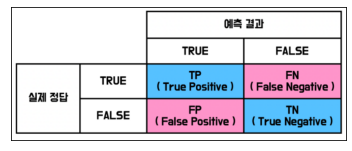

In [ ]:
open_img('https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdGmqHy%2FbtqWX4EL9Ne%2FuZeK9C5sOC6YzozhjBRFFK%2Fimg.png')

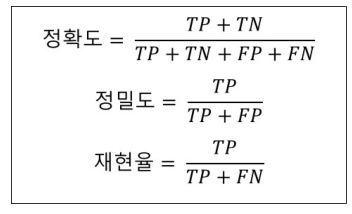

In [ ]:
open_img('https://velog.velcdn.com/images%2Fshshin%2Fpost%2Ffacdca36-f038-4d44-8042-6ed51d95d32c%2F%EC%A0%95%ED%99%95%EB%8F%84%EC%A0%95%EB%B0%80%EB%8F%84%EC%9E%AC%ED%98%84%EC%9C%A8.jpg')

In [ ]:
with open(str(path / 'ml_data' / 'X_train'), 'rb') as f:
  X_train = pickle.load(f)

with open(str(path / 'ml_data' / 'X_test'), 'rb') as f:
  X_test = pickle.load(f)

with open(str(path / 'ml_data' / 'X_val'), 'rb') as f:
  X_val = pickle.load(f)

with open(str(path / 'ml_data' / 'y_train'), 'rb') as f:
  y_train = pickle.load(f)

with open(str(path / 'ml_data' / 'y_test'), 'rb') as f:
  y_test = pickle.load(f)

with open(str(path / 'ml_data' / 'y_val'), 'rb') as f:
  y_val = pickle.load(f)

In [ ]:
# 전체 데이터로 파라미터 그리드 서치
lgb_score_ = []

lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}
max_depth = [md for md in range(4, 10)]

scoring = {'recall_score': make_scorer(recall_score, pos_label=0),
          'accuracy_score': make_scorer(accuracy_score)}

lgb_models = []

for lr in lgb_params['learning_rate']:
  for md in max_depth:
    
    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_models.append(lgb_model)

    lgb_score = cross_validate(lgb_model, X_train, y_train, scoring=scoring)
    lgb_score_.append(lgb_score)
    print(lgb_score)


In [ ]:
a_r = [[np.mean(i['test_accuracy_score']), np.mean(i['test_recall_score'])] for i in lgb_score_]

s_ = [i[0] + i[1] for i in a_r]

print(f'Max Score Index: {np.argmax(s_)}')
print(f'Max Score: {s_[np.argmax(s_)]}')

lgb_model = lgb_models[np.argmax(s_)]
lgb_model

Max Score Index: 53
Max Score: 1.9653188168083777


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.09000000000000001,
               max_depth=9, objective='binary', random_state=41, subsample=0.75,
               tree_method='gpu_hist')

Text(0.5, 1.0, 'Confusion Matrix')

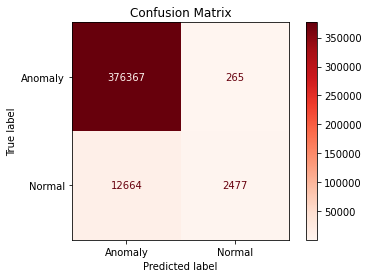

In [ ]:
lgb_model.fit(X_train, y_train)

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_train, y_train,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

최적의 accuracy 성능: 0.9663928350455467
최적의 recall 성능: 0.9991779774421716


Text(0.5, 1.0, 'Confusion Matrix')

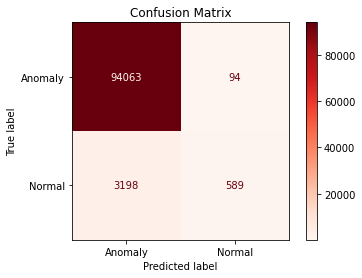

In [ ]:
y_test_pred = lgb_model.predict(X_test)

acc_1 = accuracy_score(y_test, y_test_pred)
recall_1 = recall_score(y_test, y_test_pred, pos_label=0)
print(f'최적의 accuracy 성능: {acc_1}')
print(f'최적의 recall 성능: {recall_1}')

label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_val, y_val,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

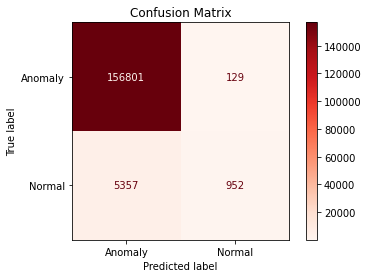

In [ ]:
label=['Anomaly', 'Normal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

## Postpreprocessing

임계점 변환을 통해 예측 정확도를 높이는 단계를 진행

In [ ]:
y_val_prob = lgb_model.predict_proba(X_val)
y_val_pred = lgb_model.predict(X_val)
score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

thr_ = np.linspace(1, 0, 10000)
idx = -1
for i, thr in enumerate(thr_):
  y_val_pred = np.where(y_val_prob[:, 0] >= thr, 0, 1)
  tmp_score = recall_score(y_val, y_val_pred, pos_label=0) + accuracy_score(y_val, y_val_pred)

  if score < tmp_score:
    score = tmp_score
    idx = i
    print(f'idx: {idx}\tscore: {score}')

  if i % 1000 == 0:
    print(f'현재 index: {i}')
    
print(f'idx: {idx}')    
print(f'새로운 threshold: {thr_[idx]}')

현재 index: 0
현재 index: 1000
현재 index: 2000
현재 index: 3000
현재 index: 4000
idx: 4979	score: 1.9654212541304124
현재 index: 5000
idx: 5086	score: 1.9654445484660115
idx: 5094	score: 1.9654449591094196
idx: 5270	score: 1.9654482442566867
idx: 5288	score: 1.9654588648159654
현재 index: 6000
idx: 6216	score: 1.9654650806364293
현재 index: 7000
현재 index: 8000
현재 index: 9000
idx: 6216
새로운 threshold: 0.37833783378337826


Text(0.5, 1.0, 'Confusion Matrix')

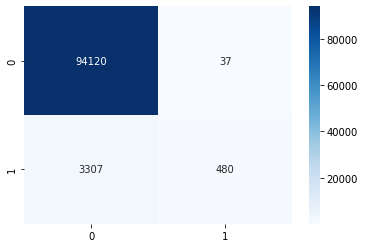

In [ ]:
y_val_pred = np.where(y_val_prob[:, 0] > thr_[idx], 0, 1)

sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')
plot.ax_.set_title('Confusion Matrix')

새로운 모델 및 임계점에 따른 혼동행렬 결과


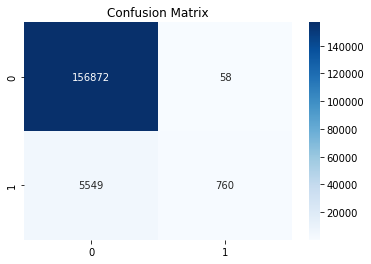

In [ ]:
y_test_prob = lgb_model.predict_proba(X_test)

y_test_pred = np.where(y_test_prob[:, 0] > thr_[idx], 0, 1)

print(f'새로운 모델 및 임계점에 따른 혼동행렬 결과')

acc_2 = accuracy_score(y_test, y_test_pred)
recall_2 = recall_score(y_test, y_test_pred, pos_label=0)


plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True,
                             cmap=plt.cm.Blues, fmt='g')

(0.95, 1.0)

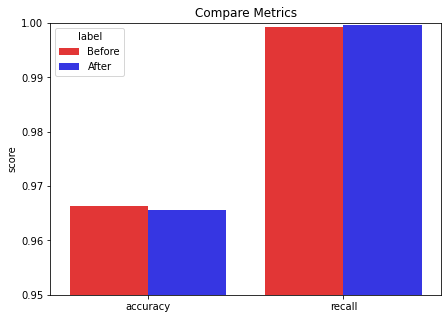

In [ ]:
# 후처리 성능 비교
colors = ["red", "blue"]
sns.set_palette(sns.color_palette(colors))

postprocessing_result = pd.DataFrame({'Name':['accuracy','accuracy', 'recall', 'recall'],
                         'label':['Before', 'After', 'Before', 'After'],
                         'score':[acc_1, acc_2, recall_1, recall_2]})

plt.figure(figsize=(7, 5))
plt.title('Compare Metrics')
ax = sns.barplot(x="Name", y="score", hue="label", data=postprocessing_result, alpha=0.9)
plt.xlabel('')
plt.ylim(0.95, 1)

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=0.09000000000000001, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=9, skip_drop = 0.37833783378337826)

lgb_model.fit(X_train, y_train)

with open(str(path / 'save_model' /'jeju_model.pickle'),'wb') as fw:
  pickle.dump(lgb_model, fw)

In [ ]:
X_pred_prob_ = jeju_df[jeju_df.LABEL == 1]

X_pred_prob_.pop('LABEL')

X_pred_prob = X_pred_prob_.reset_index(drop=True)

X_pred_prob = preprocess_type(X_pred_prob)

X_pred_prob = preprocess_test_nominal(X_pred_prob, oh_encoder)

X_pred_prob = lgb_model.predict_proba(X_pred_prob)

X_pred_prob_['PROB'] = X_pred_prob[:, 0]

In [ ]:
jeju_safe_re = pd.read_csv(str(path / 'safe_re' / 'jeju_safe.csv'))

with open(str(path / 'ml_data' /'jeju_prob.pickle'),'rb') as f:
  X_pred_prob = pickle.load(f)

jeju_safe_1 = jeju_safe_re[['LATITUDE','LONGITUDE','STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD', 'MEAN', 'STDDEV', 'MIN', 'MAX', 'STATION_ID']]

c = ['SEED']
jeju_safe_1 = jeju_safe_1.reset_index(drop=True)
col_list = list(jeju_safe_1.columns)
jeju_safe_1 = jeju_safe_1.reset_index()
c.extend(col_list)
jeju_safe_1.columns = c

for c in jeju_safe_1.columns:
  if c in ['SEED', 'STORUNST', 'FROR_CD', 'FRTP_CD', 'KOFTR_GROU', 'LOCAL_CD', 'STATION_ID']:
    jeju_safe_1[c] = jeju_safe_1[c].astype(int)
  else:
    jeju_safe_1[c] = jeju_safe_1[c].astype(float)

with open(str(path / 'safe_data' /'JEJU_SAFE'),'wb') as fw:
  pickle.dump(jeju_safe_1, fw)

jeju_safe_1

In [ ]:
jeju_safe_1

,SEED,LATITUDE,LONGITUDE,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,LOCAL_CD,MEAN,STDDEV,MIN,MAX,STATION_ID
0,0,879282.705844,1.484652e+06,0,0,0,91,50110,37117.748899,16412.779697,3675.263775,69232.975867,185
1,1,884557.161745,1.491034e+06,0,0,0,91,50110,32858.105210,14298.051542,4203.285997,62408.830664,185
2,2,891998.998526,1.496779e+06,0,0,0,91,50110,28805.009634,10751.427939,7294.294468,56735.754914,184
3,3,891175.304095,1.549479e+06,0,0,0,91,50110,66990.360069,8398.408920,4890.361694,79886.332406,184
4,4,890267.575159,1.482666e+06,0,0,0,92,50110,27798.086338,15496.554958,3213.972903,70739.416419,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25232,25232,935939.088568,1.481556e+06,2,0,0,83,50130,26413.457029,13818.143134,3287.666417,86465.262065,188
25233,25233,935647.097904,1.483164e+06,2,0,0,83,50130,25621.282018,14059.652920,3547.171210,84968.418044,188
25234,25234,927407.814000,1.482960e+06,2,0,0,83,50130,20329.523536,12838.645899,2244.535388,80790.511864,188
25235,25235,926479.166435,1.484542e+06,2,0,0,83,50130,19260.019005,12921.211642,1014.581978,78956.422223,188
